In [154]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.regularizers import l2


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

print(tf.__version__)

2.10.0


In [155]:

# Load the data into a pandas dataframe
data_path = "../data/malware_dataset.csv"
data = pd.read_csv(data_path)

# Convert classification column from string values into numerical values
# 0 - malware , 1 - benign
le = LabelEncoder()
data["classification"] = le.fit_transform(data["classification"])

# Drop the classification from input data and pass it in as output
features = data.drop(columns=["classification"])

print(features.shape)

# Perform PCA to reduce dimensionaliy
# ty
pca = PCA(n_components=34)
features = pca.fit_transform(features)

# Normalize features
# Mean of 0 and Standard deviation of 1 to highlight large features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    features, data["classification"], test_size=0.2, random_state=42)


enc = OneHotEncoder()
train_labels = enc.fit_transform(train_labels.values.reshape(-1, 1)).toarray()
test_labels = enc.transform(test_labels.values.reshape(-1, 1)).toarray()


(100000, 34)


In [156]:
# PCA "n_components" output
input_dim = 34

input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(64, activation='relu')(input_layer)
encoder = tf.keras.layers.Dense(32, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(32, activation='relu')(encoder)

# Build decoder network
decoder = tf.keras.layers.Dense(32, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(64, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='linear')(decoder)

# Combine encoder and decoder into autoencoder
autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_281 (Dense)           (None, 64)                2240      
                                                                 
 dense_282 (Dense)           (None, 32)                2080      
                                                                 
 dense_283 (Dense)           (None, 32)                1056      
                                                                 
 dense_284 (Dense)           (None, 32)                1056      
                                                                 
 dense_285 (Dense)           (None, 64)                2112      
                                                                 
 dense_286 (Dense)           (None, 34)                2210

In [157]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = autoencoder.fit(train_data, train_data, epochs=10,
                batch_size=128, verbose=1)

Epoch 1/10
625/625 [==============================] - 1s 739us/step - loss: 0.7790 - accuracy: 0.4977
Epoch 2/10
625/625 [==============================] - 1s 821us/step - loss: 0.5892 - accuracy: 0.6829
Epoch 3/10
625/625 [==============================] - 0s 749us/step - loss: 0.5207 - accuracy: 0.7535
Epoch 4/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5056 - accuracy: 0.7464
Epoch 5/10
625/625 [==============================] - 0s 743us/step - loss: 0.4638 - accuracy: 0.7561
Epoch 6/10
625/625 [==============================] - 0s 737us/step - loss: 0.4288 - accuracy: 0.7656
Epoch 7/10
625/625 [==============================] - 0s 755us/step - loss: 0.4222 - accuracy: 0.7661
Epoch 8/10
625/625 [==============================] - 0s 747us/step - loss: 0.3666 - accuracy: 0.7839
Epoch 9/10
625/625 [==============================] - 0s 736us/step - loss: 0.3129 - accuracy: 0.7956
Epoch 10/10
625/625 [==============================] - 1s 851us/step - loss: 0.3104 

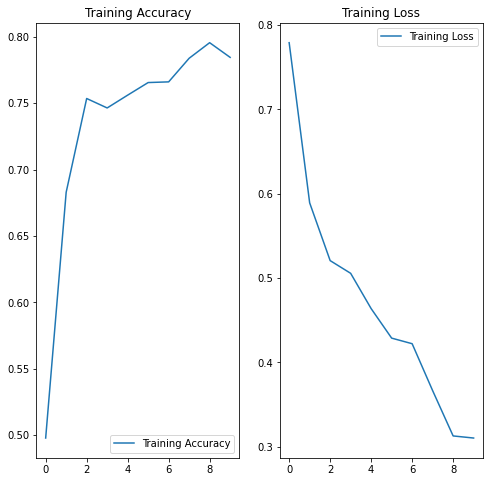

In [158]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()


In [159]:
# Detect Anomalies through this
reconstructions = autoencoder.predict(test_data)
reconstruction_error = np.mean(np.abs(reconstructions - test_data), axis=1)
threshold = np.mean(reconstruction_error) + np.std(reconstruction_error)
anomalies = np.where(reconstruction_error > threshold, 1, 0)

625/625 [==============================] - 0s 276us/step


In [160]:
print(train_labels.shape)

(80000, 2)


In [161]:
classification = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(34,),
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

classification.compile(optimizer='sgd', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                       metrics=['accuracy'])

history = classification.fit(train_data, train_labels, epochs=10,
                             batch_size=128,
                             verbose=1)


Epoch 1/10
  1/625 [..............................] - ETA: 2:03 - loss: 2.2056 - accuracy: 0.4766

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/keras/backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


625/625 [==============================] - 1s 561us/step - loss: 1.9379 - accuracy: 0.5496
Epoch 2/10
625/625 [==============================] - 0s 536us/step - loss: 1.5892 - accuracy: 0.6826
Epoch 3/10
625/625 [==============================] - 0s 535us/step - loss: 1.2659 - accuracy: 0.8096
Epoch 4/10
625/625 [==============================] - 0s 537us/step - loss: 0.9620 - accuracy: 0.8876
Epoch 5/10
625/625 [==============================] - 0s 545us/step - loss: 0.7541 - accuracy: 0.9267
Epoch 6/10
625/625 [==============================] - 0s 553us/step - loss: 0.6125 - accuracy: 0.9443
Epoch 7/10
625/625 [==============================] - 0s 531us/step - loss: 0.5098 - accuracy: 0.9539
Epoch 8/10
625/625 [==============================] - 0s 529us/step - loss: 0.4288 - accuracy: 0.9627
Epoch 9/10
625/625 [==============================] - 0s 529us/step - loss: 0.3700 - accuracy: 0.9702
Epoch 10/10
625/625 [==============================] - 0s 530us/step - loss: 0.3272 - accurac

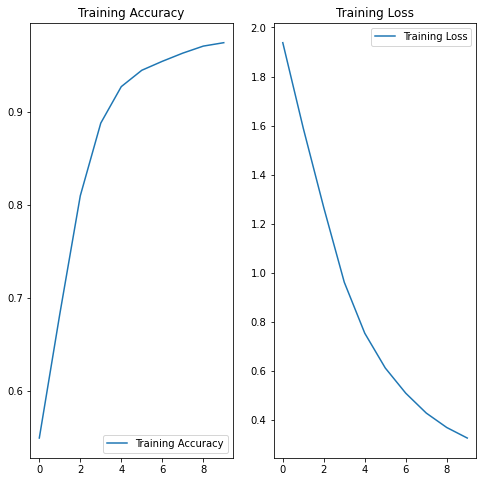

In [162]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [163]:
predictions = classification.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

625/625 [==============================] - 0s 308us/step


In [164]:
# Only using the classification model
predictions = classification.predict(test_data)

num_correct = 0
for i in range(len(predictions)):
    if predictions[i][0] == 0:
        print("Data point", i, "predicted as 'benign'")
    else:
        print("Data point", i, "predicted as 'malware'")

    if np.argmax(predictions[i]) == np.argmax(test_labels[i]):
        print("Prediction for data point", i, "is correct")
        num_correct = num_correct + 1
    else:
        print("Prediction for data point", i, "is incorrect")

print("Number of correct predictions: " + str(num_correct))
print("Accuracy:", num_correct/len(predictions))


625/625 [==============================] - 0s 257us/step
Data point 0 predicted as 'malware'
Prediction for data point 0 is correct
Data point 1 predicted as 'malware'
Prediction for data point 1 is correct
Data point 2 predicted as 'malware'
Prediction for data point 2 is correct
Data point 3 predicted as 'malware'
Prediction for data point 3 is correct
Data point 4 predicted as 'malware'
Prediction for data point 4 is correct
Data point 5 predicted as 'malware'
Prediction for data point 5 is correct
Data point 6 predicted as 'malware'
Prediction for data point 6 is correct
Data point 7 predicted as 'malware'
Prediction for data point 7 is correct
Data point 8 predicted as 'malware'
Prediction for data point 8 is correct
Data point 9 predicted as 'malware'
Prediction for data point 9 is correct
Data point 10 predicted as 'malware'
Prediction for data point 10 is correct
Data point 11 predicted as 'malware'
Prediction for data point 11 is correct
Data point 12 predicted as 'malware'
Pr

In [165]:
print("Shape of predictions array:", predictions.shape)
print("Shape of test labels array:", test_labels.shape)


Shape of predictions array: (20000, 2)
Shape of test labels array: (20000, 2)


In [166]:
# Ensembling module
# Predictions and Anomalies
def majority_voting(predictions1, predictions2):
    combined_predictions = np.zeros(predictions1.shape)
    for i in range(len(predictions1)):
        combined_predictions = np.concatenate(
            [predictions1, predictions2], axis=1)
        majority_voting_predictions = np.argmax(combined_predictions, axis=1)
        return majority_voting_predictions

In [167]:
def test_random_id(model1, model2, test_data, test_labels):
    # Choose a random id from the test set
    random_id = np.random.randint(0, len(test_data))
    # Get the corresponding data and label
    data = test_data[random_id]
    label = test_labels[random_id]
    # Reshape the data to match the input shape of the models
    data = data.reshape(1, -1)
    # Make predictions using both models
    predictions1 = model1.predict(data)
    predictions2 = model2.predict(data)
    # Combine the predictions using majority voting
    if len(predictions1) == 1:
        combined_predictions = predictions1
    else:
        combined_predictions = majority_voting(predictions1, predictions2)
    # Get the predicted label
    predicted_label = combined_predictions[0]
    # Convert the scalar label to a one-hot encoded array
    label = np.array([1, 0]) if label == 0 else np.array([0, 1])
    # Check if the prediction matches the true label
    if np.array_equal(predicted_label, label):
        accuracy = "Correct"
    else:
        accuracy = "Incorrect"

    # Print the results
    print("Random ID:", random_id)
    print("True label:", "malware" if label[1] == 1 else "benign")
    print("Predicted label:",
          "malware" if predicted_label[1] == 1 else "benign")
    print("Accuracy:", accuracy)


test_random_id(autoencoder, classification, test_data, test_labels)


1/1 [==============================] - 0s 28ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [168]:
# MODEL TYPE 1 -> EncodedData -> (fed as input into classification model) -> Classification Model Outputs (Malware or Benign)

# Train the autoencoder
from sklearn.metrics import accuracy_score

test_labels_indices = np.argmax(test_labels, axis=1)


# Transform the training and test data using the autoencoder
encoded_train_data = autoencoder.predict(train_data)
encoded_test_data = autoencoder.predict(test_data)

# Evaluate the classification model on the encoded test data
accuracy_with_autoencoder = classification.evaluate(
    encoded_test_data, test_labels)[1]

# Evaluate the classification model on the original test data
accuracy_without_autoencoder = classification.evaluate(test_data, test_labels)[
    1]

# Make predictions on the test data
individual_predictions = classification.predict(test_data)
encoded_predictions = classification.predict(encoded_test_data)

# Combine the predictions with the individual models using majority voting
majority_voting_predictions = majority_voting(
    encoded_predictions, individual_predictions)


# Evaluate the performance of the ensembling module
accuracy_ensembling = accuracy_score(test_labels, majority_voting_predictions)

# Print the results
print("Accuracy with autoencoder and ensembling:", accuracy_ensembling)
print("Accuracy with autoencoder only:", accuracy_with_autoencoder)
print("Accuracy without autoencoder:", accuracy_without_autoencoder)

625/625 [==============================] - 0s 263us/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
print(test_labels)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
# MODEL TYPE 2 -> EncodedData -> -> Classification Model Outputs (Malware or Benign) -> (Both are fed separately as input into ensembling model)


# Transform the training and test data using the autoencoder
encoded_train_data = autoencoder.predict(train_data)
encoded_test_data = autoencoder.predict(test_data)

test_labels = test_labels.reshape(-1,)

# Evaluate the classification model on the encoded test data
accuracy_with_autoencoder = classification.evaluate(
    encoded_test_data, test_labels)[1]

# Evaluate the classification model on the original test data
accuracy_without_autoencoder = classification.evaluate(test_data, test_labels)[
    1]

# Make predictions on the test data
individual_predictions = classification.predict(test_data)
encoded_predictions = classification.predict(encoded_test_data)

# Combine the predictions with the individual models using majority voting
majority_voting_predictions = majority_voting(
    encoded_predictions, individual_predictions)


# Evaluate the performance of the ensembling module
accuracy_ensembling = accuracy_score(test_labels, majority_voting_predictions)

# Print the results
print("Accuracy with autoencoder and ensembling:", accuracy_ensembling)
print("Accuracy with autoencoder only:", accuracy_with_autoencoder)
print("Accuracy without autoencoder:", accuracy_without_autoencoder)


625/625 [==============================] - 0s 273us/step


ValueError: Data cardinality is ambiguous:
  x sizes: 20000
  y sizes: 40000
Make sure all arrays contain the same number of samples.